In [1]:
from magis_sigdial2020.models.xkcd_model import CompositionalModel, CompositionalXKCDModel
from magis_sigdial2020.hyper_params import HyperParameters
from magis_sigdial2020.datasets.xkcd.vectorized import CompositionalXKCD, XKCD, get_comp_xkcd_vocab, get_xkcd_vocab
from magis_sigdial2020.utils.plot import CompositionalColorspacePlotter
from magis_sigdial2020 import settings
import pyromancy
from pyromancy.utils import get_args
import pyromancy.reader as reader
import pyromancy.subscribers as sub
import numpy as np
import pandas as pd
import torch
import os

# Dataset

Words role as modifier or head or both <br>
Most common modifiers <br>
Most common heads

In [2]:
vocabulary = get_comp_xkcd_vocab()
dataset = CompositionalXKCD.from_settings(coordinate_system = 'hue') #using hue coordinate systems, should figure out the signifigance of each coordinate system

color_descriptions = get_xkcd_vocab().keys()
color_descriptions = [list(reversed(color_description.split())) for color_description in color_descriptions]
color_descriptions = [[vocabulary.lookup_token(color_word) for color_word in color_description] for color_description in color_descriptions]
for i in range(len(color_descriptions)):
    color_descriptions[i] = np.array(color_descriptions[i])
    color_descriptions[i].resize(3)
color_descriptions = np.array(color_descriptions)

In [3]:
#dataframe with cols: color word, total occurrence, occurrence at positions 0, 1, 2, 3, 4, 5
vocab_freq_df = pd.DataFrame({'Color Word': vocabulary.keys(),
                    'Frequency': [(color_descriptions==i).sum() for i in range(1,340)],
                    'Frequency at 0': [(color_descriptions==i).sum(axis=0)[0] for i in range(1,340)],
                    'Frequency at 1': [(color_descriptions==i).sum(axis=0)[1] for i in range(1,340)],
                    'Frequency at 2': [(color_descriptions==i).sum(axis=0)[2] for i in range(1,340)],
                    })
vocab_freq_df.index+=1

In [4]:
vocab_freq_df.loc[vocab_freq_df['Frequency at 0']>0].sort_values(by = 'Frequency at 0', ascending = False).head(30)

,Color Word,Frequency,Frequency at 0,Frequency at 1,Frequency at 2
134,green,157,151,6,0
32,blue,107,98,9,0
244,purple,49,44,5,0
229,pink,46,44,2,0
45,brown,41,36,5,0
251,red,40,35,5,0
337,yellow,41,32,9,0
215,orange,27,24,3,0
137,grey,30,23,7,0
306,teal,12,10,2,0


In [5]:
vocab_freq_df.loc[vocab_freq_df['Frequency at 1']>0].sort_values(by = 'Frequency at 1', ascending = False).head(30)

,Color Word,Frequency,Frequency at 0,Frequency at 1,Frequency at 2
171,light,66,0,45,21
87,dark,60,0,45,15
219,pale,32,1,26,5
42,bright,26,0,20,6
90,deep,14,0,13,1
337,yellow,41,32,9,0
99,dull,9,0,9,0
32,blue,107,98,9,0
102,dusty,8,0,8,0
135,greenish,9,1,8,0


In [6]:
vocab_freq_df.loc[vocab_freq_df['Frequency at 2']>0].sort_values(by = 'Frequency at 2', ascending = False)

,Color Word,Frequency,Frequency at 0,Frequency at 1,Frequency at 2
171,light,66,0,45,21
87,dark,60,0,45,15
323,very,9,0,0,9
42,bright,26,0,20,6
219,pale,32,1,26,5
20,baby,7,0,4,3
43,british,1,0,0,1
90,deep,14,0,13,1
98,duck,1,0,0,1
116,fire,1,0,0,1


# Plotting Utils

In [7]:
def get_specific_args(exp_name, trial_name):
    exp = reader.SingleExperimentReader(exp_name, filter_unfinished = False)
    trial_map = {os.path.split(trial_path)[1]: trial_path for trial_path in exp.all_trial_paths}
    args = get_args(trial_map[trial_name])
    args.trial_path = trial_map[trial_name]
    return args

compositional_xkcd_model = CompositionalXKCDModel.make(
    get_specific_args('E007_CompositionalXKCDModel', 'trial6'),
    reload=True, eval_mode=True)

comp_plotter = CompositionalColorspacePlotter(compositional_xkcd_model, coordinate_system="hue", cuda=False)

# Contour over colorspace

## Basic one word colors <br>
Black is low in saturation and value, and varied in hue <br>
White is low in saturation, low in hue, and high in value <br>
Brown has low hue and medium saturation and value <br>
Going along the rainbow seems to move the mass toward the lower right on the left plot (higher hue and lower saturation) <br>

Translated to indices: [ 1 30  2]
Selected indices: [30  2]


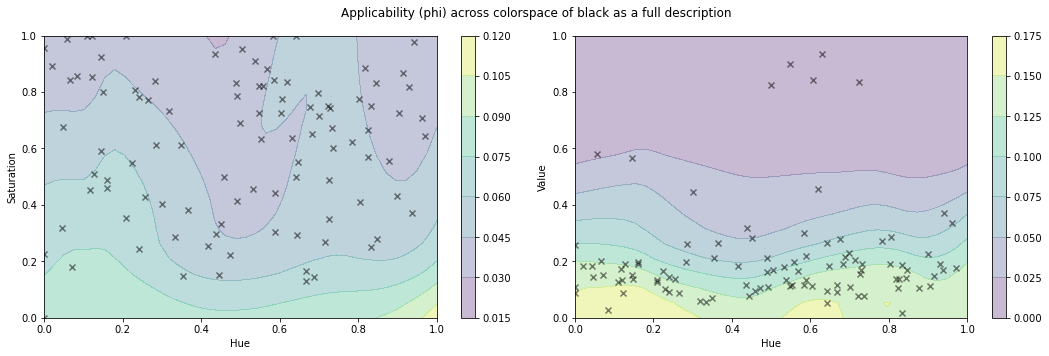

In [8]:
comp_plotter.contour_plot_full_color_term("black", [0,1], target='phi',num_to_scatter=100)

Translated to indices: [ 1 30  2]
Seq positions: [0 1]
Selected indices: [30  2]


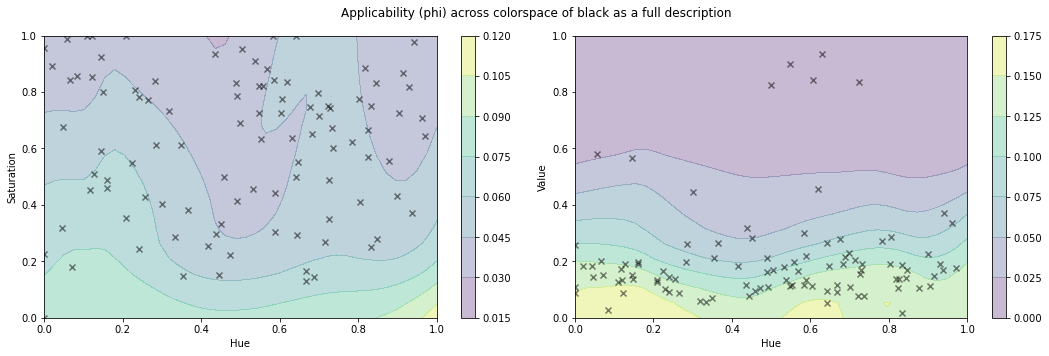

In [9]:
comp_plotter.contour_plot_full_color_term("black", target='phi',num_to_scatter=100)

Translated to indices: [  1 333   2]
Selected indices: [333   2]


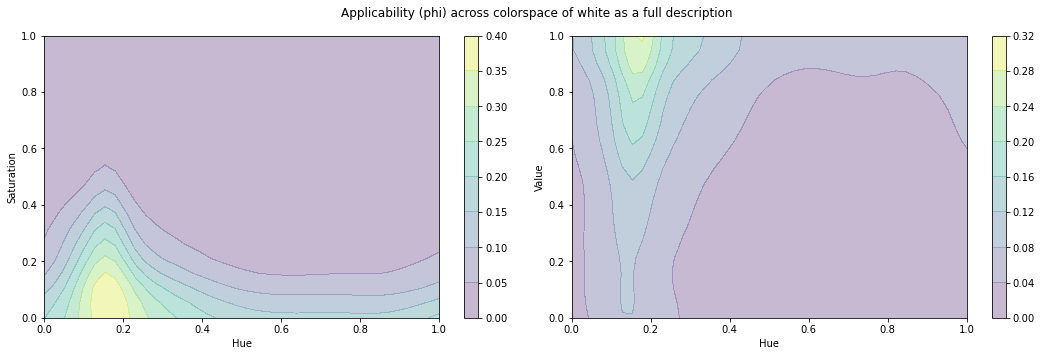

In [10]:
comp_plotter.contour_plot_full_color_term("white", [0,1], target='phi')

Translated to indices: [ 1 45  2]
Selected indices: [45  2]


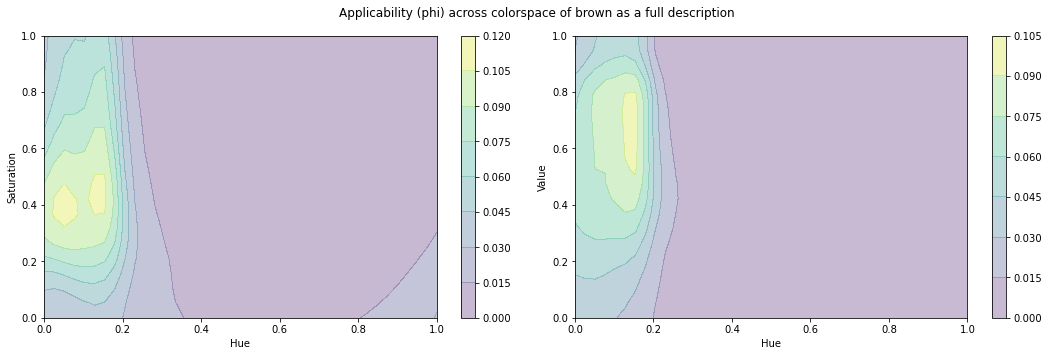

In [11]:
comp_plotter.contour_plot_full_color_term("brown", [0,1], target='phi')

Translated to indices: [  1 251   2]
Selected indices: [251   2]


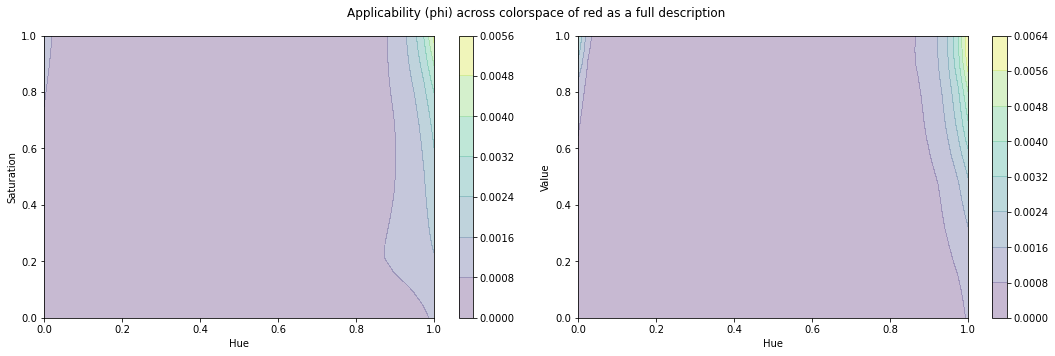

In [12]:
comp_plotter.contour_plot_full_color_term("red", [0,1], target='phi')

Translated to indices: [  1 215   2]
Selected indices: [215   2]


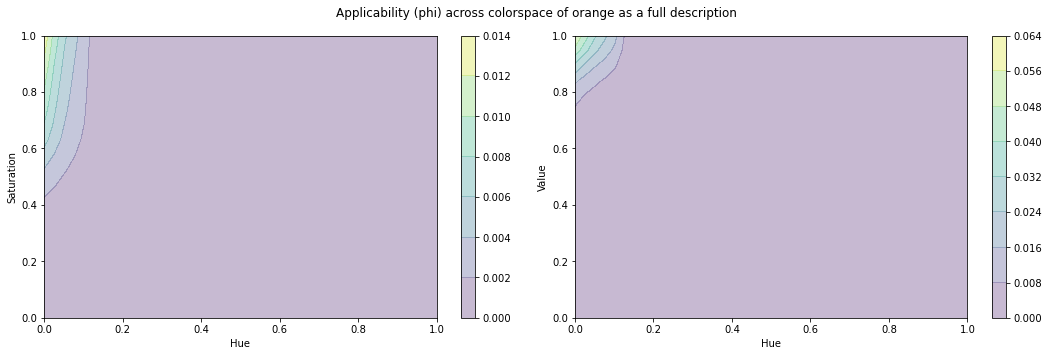

In [13]:
comp_plotter.contour_plot_full_color_term("orange", [0,1], target='phi')

Translated to indices: [  1 337   2]
Selected indices: [337   2]


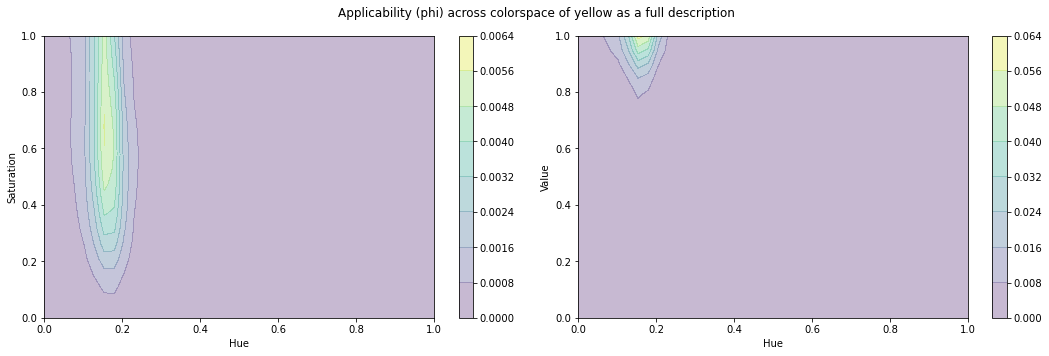

In [14]:
comp_plotter.contour_plot_full_color_term("yellow", [0,1], target='phi')

Translated to indices: [  1 134   2]
Selected indices: [134   2]


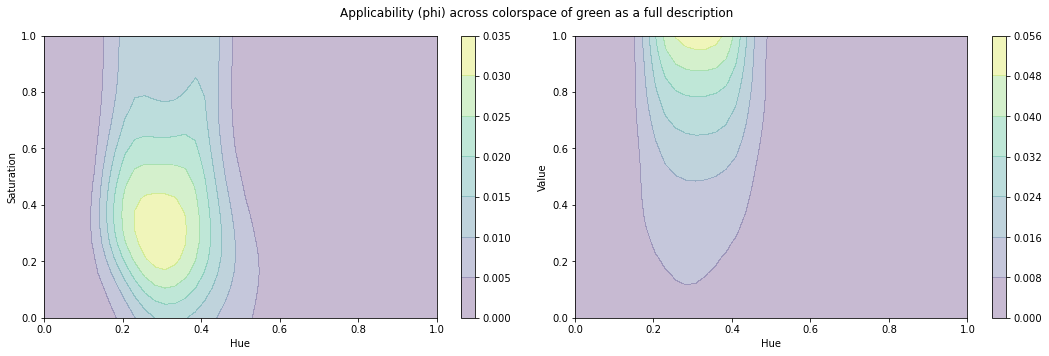

In [15]:
comp_plotter.contour_plot_full_color_term("green", [0,1], target='phi')

Translated to indices: [ 1 32  2]
Selected indices: [32  2]


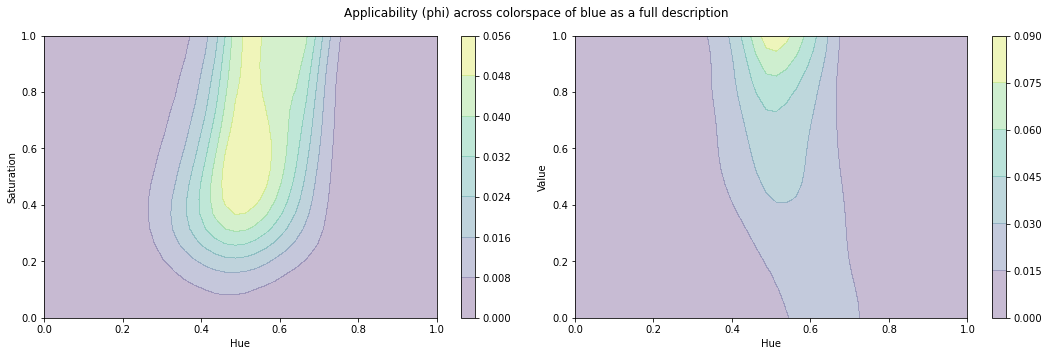

In [16]:
#The applicability of "blue" as a full descriptioon
comp_plotter.contour_plot_full_color_term("blue", [0,1], target='phi')

Translated to indices: [  1 244   2]
Selected indices: [244   2]


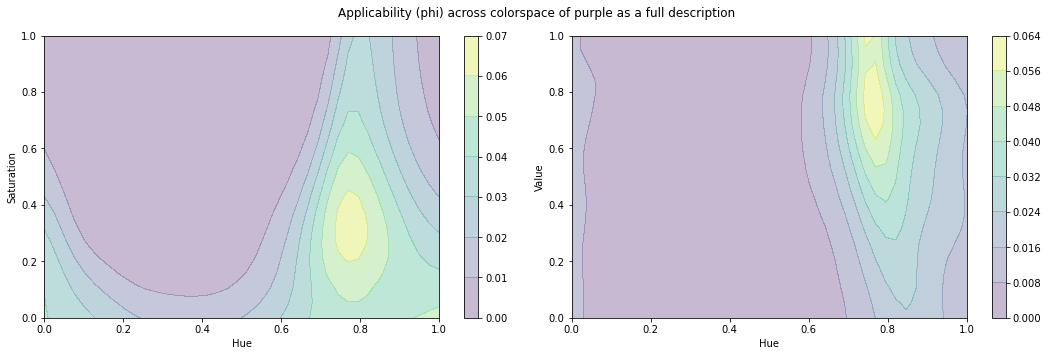

In [17]:
#The applicability of "purple" as a full descriptioon
comp_plotter.contour_plot_full_color_term("purple", [0,1], target='phi')

## Modifier "light"

For purple, "light" brought saturation down and value up

Translated to indices: [  1 244   2]
Selected indices: [244   2]


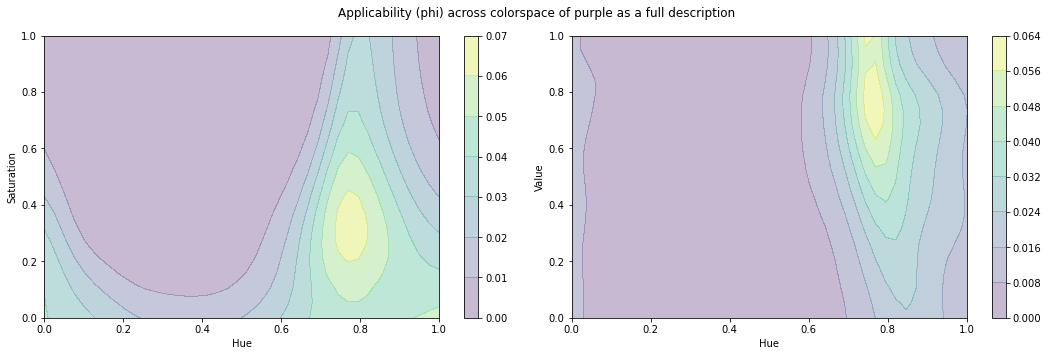

In [18]:
comp_plotter.contour_plot_full_color_term("purple", [0,1], target='phi')

Translated to indices: [  1 244 171   2]
Selected indices: [244 171   2]


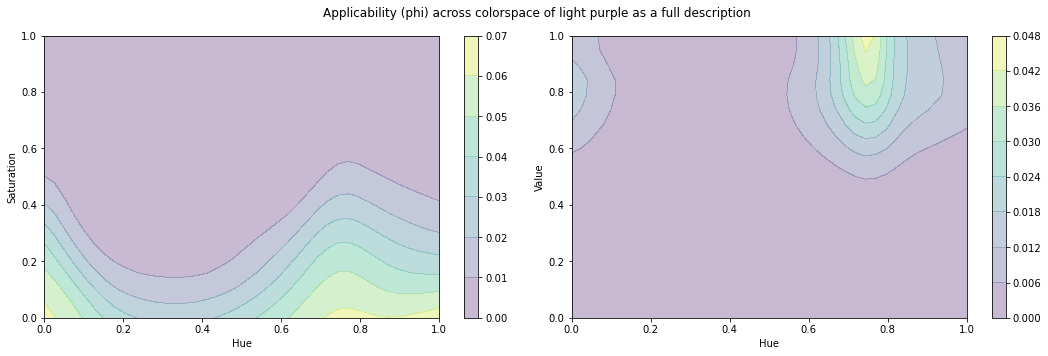

In [19]:
comp_plotter.contour_plot_full_color_term("light purple", [0,1,2], target='phi')

for green, "light" did not change the average hue, saturation, value, but it reduced the range. <br>
Seems that speakers use "green" as much as "light green" for lighter shades of green (the colors in the yellow mass). Defining something as "light green" just removes the shades that were darker green from the set of shades the description applies to

Translated to indices: [  1 134   2]
Selected indices: [134   2]


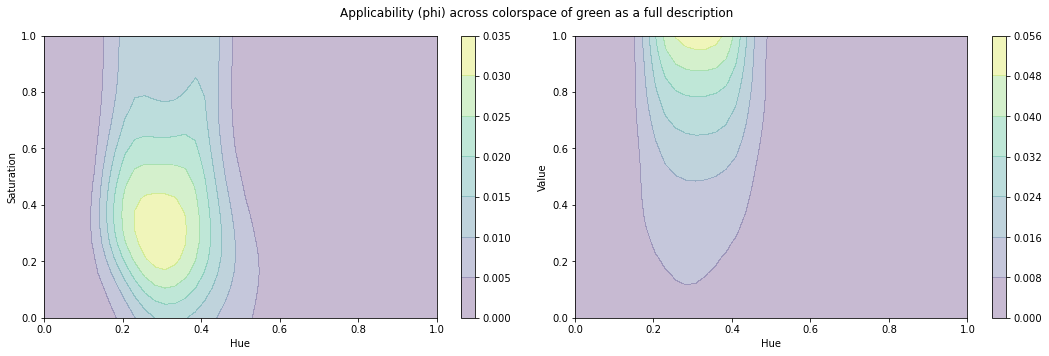

In [20]:
comp_plotter.contour_plot_full_color_term("green", [0,1], target='phi')

Translated to indices: [  1 134 171   2]
Selected indices: [134 171   2]


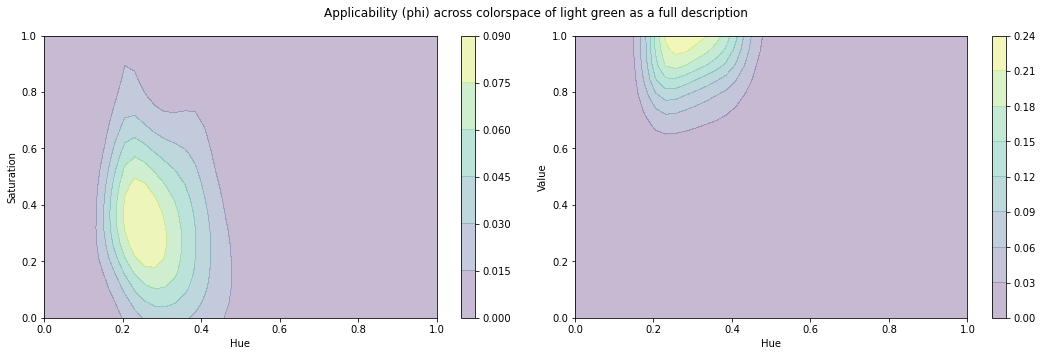

In [21]:
comp_plotter.contour_plot_full_color_term("light green", [0,1,2], target='phi')

blue

Translated to indices: [ 1 32  2]
Selected indices: [32  2]


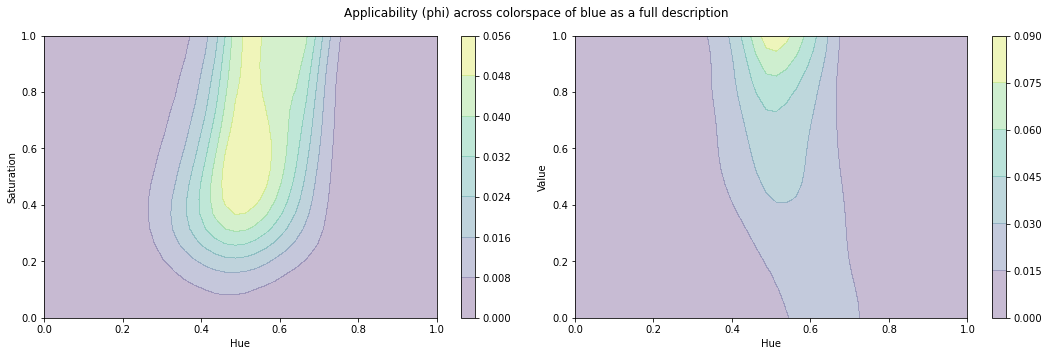

In [22]:
comp_plotter.contour_plot_full_color_term("blue", [0,1], target='phi')

Translated to indices: [  1  32 171   2]
Selected indices: [ 32 171   2]


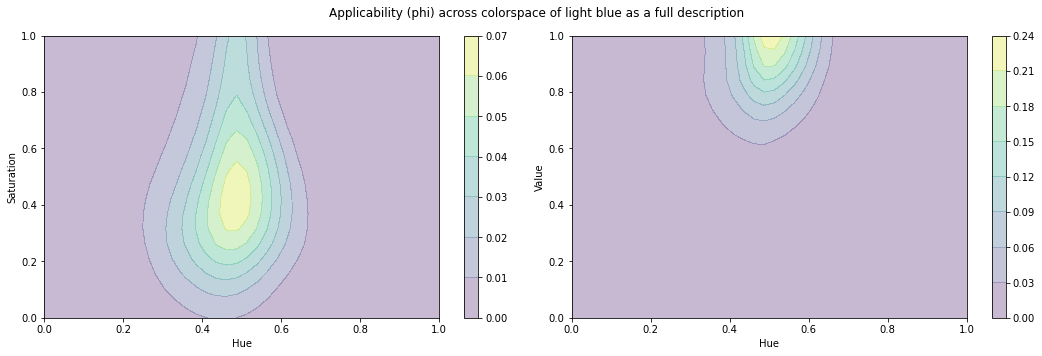

In [23]:
comp_plotter.contour_plot_full_color_term("light blue", [0,1,2], target='phi')

## bluish green vs greenish blue <br>

bluish green

Translated to indices: [  1 134  36   2]
Selected indices: [36]


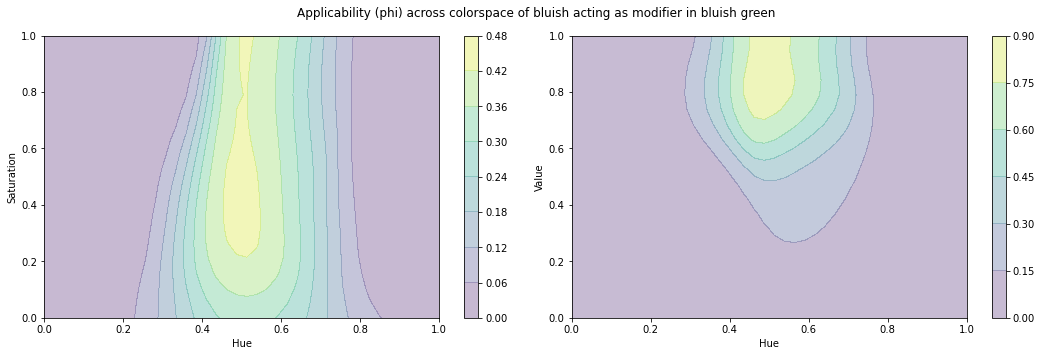

In [24]:
#the applicability "bluish" given the head word was "green"
comp_plotter.contour_plot_full_color_term("bluish green", [1], target='phi')

Translated to indices: [  1 134  36   2]
Selected indices: [134]


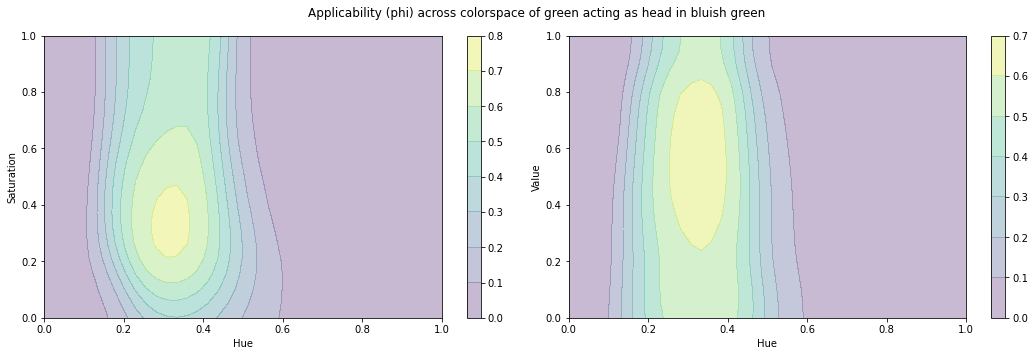

In [25]:
comp_plotter.contour_plot_full_color_term("bluish green", [0], target='phi')

Translated to indices: [  1  32 135   2]
Selected indices: [ 32 135]


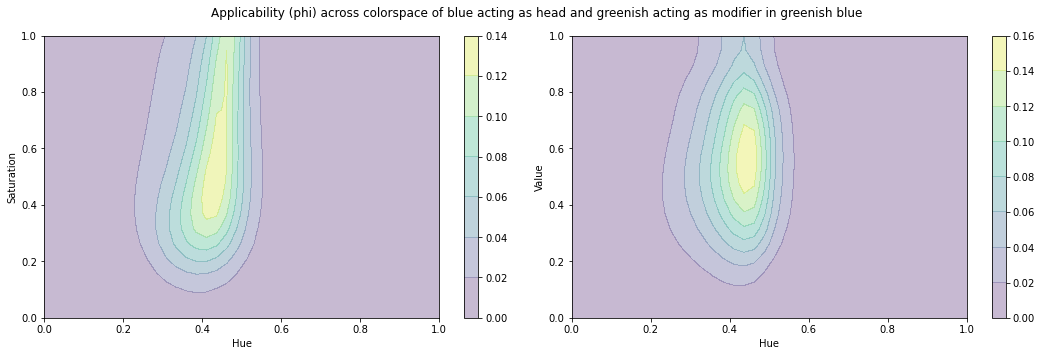

In [26]:
#applicability of the whole phrase "greenish blue"
comp_plotter.contour_plot_full_color_term("greenish blue", [0,1], target = 'phi')

Translated to indices: [  1  32 135   2]
Selected indices: [ 32 135   2]


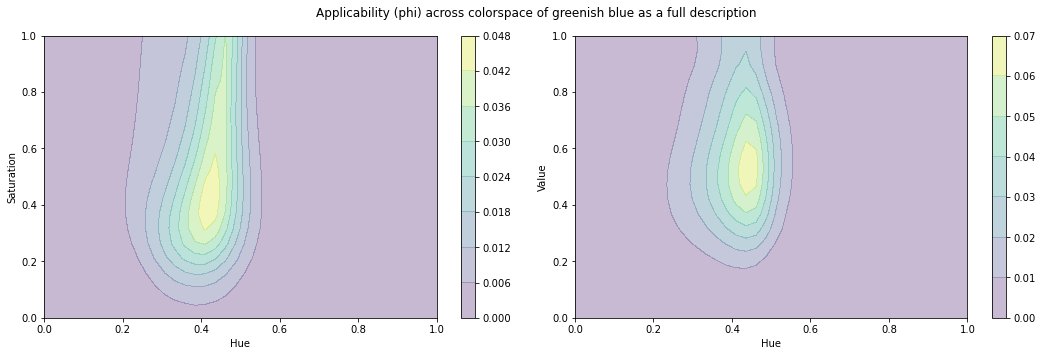

In [27]:
#applicability of the whole phrase "greenish blue"
comp_plotter.contour_plot_full_color_term("greenish blue", [0,1,2], target = 'phi')

Translated to indices: [  1  32 135   2]
Selected indices: [135]


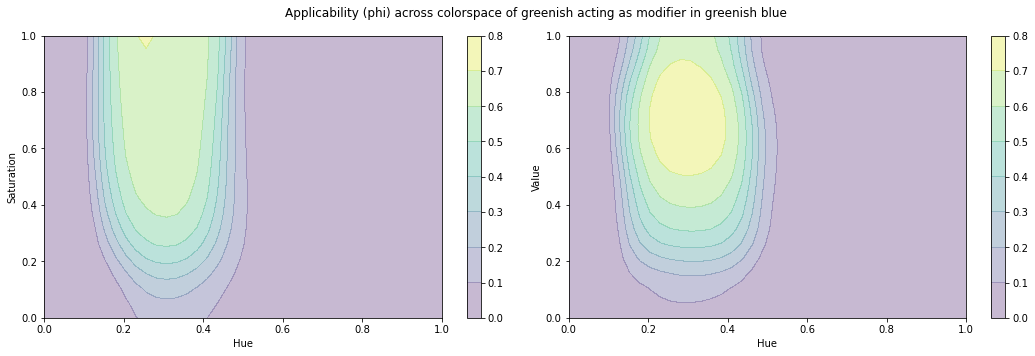

In [28]:
#the applicability "greenish" given the head word was "blue"
comp_plotter.contour_plot_full_color_term("greenish blue", [1], target='phi')

# Scatter Plots

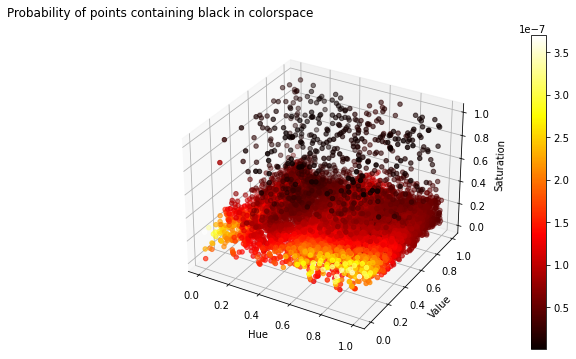

In [29]:
comp_plotter.scatter_plot_subset_color_term("black", [1])

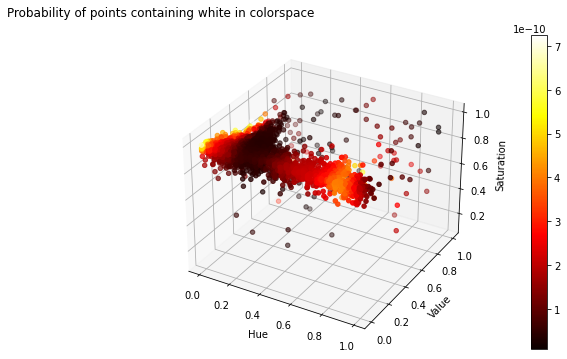

In [30]:
comp_plotter.scatter_plot_subset_color_term("white", [1])

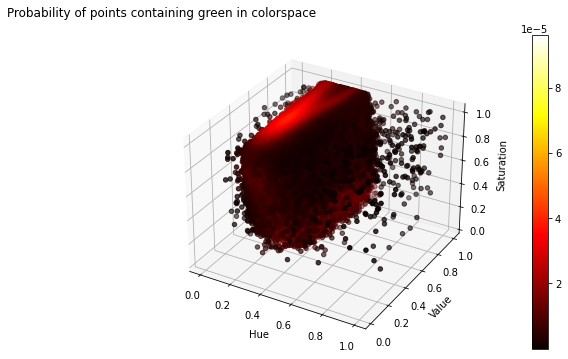

In [31]:
comp_plotter.scatter_plot_subset_color_term("green", [1])

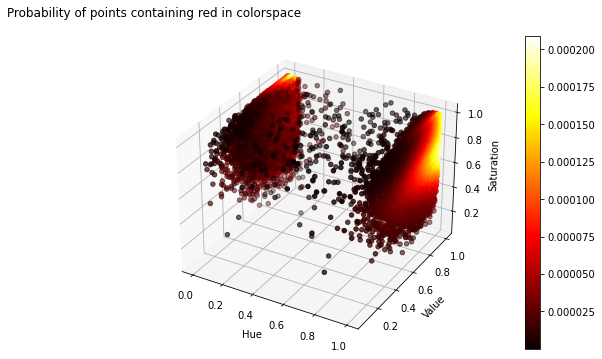

In [32]:
comp_plotter.scatter_plot_subset_color_term("red", [1])

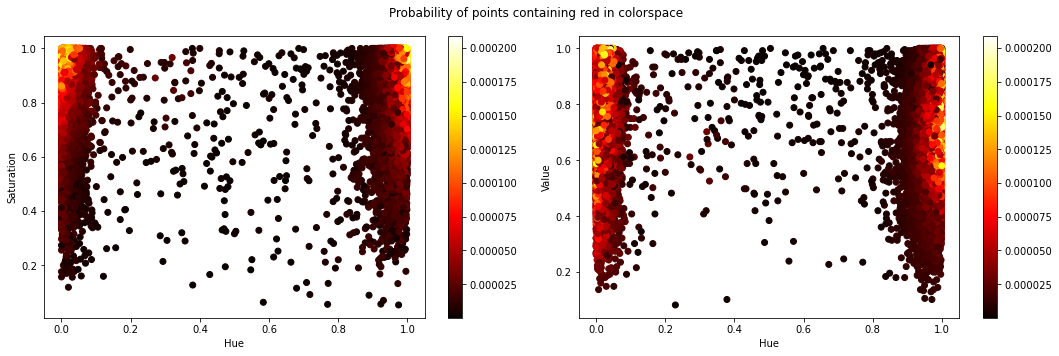

In [33]:
comp_plotter.scatter_plot_subset_color_term("red", [1], dim = '2d')

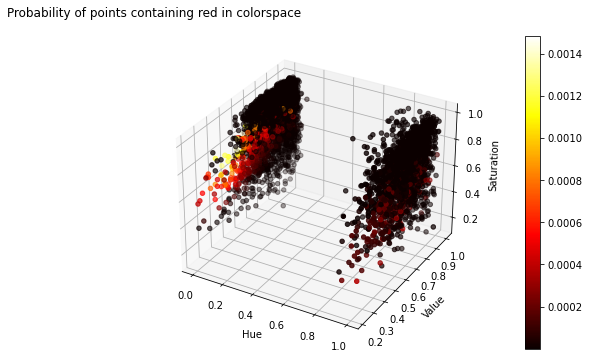

In [34]:
comp_plotter.scatter_plot_subset_color_term("red", [2])

<b> Do the phi values learned correspond to constrained meanings? </b> <br>
Varying modifiers: green vs. light green vs. dark green vs. neon green vs. blue green <br>
Varying heads: neon green vs. neon yellow vs. neon blue <br>
greenish blue vs bluish green <br>
Multiple modifiers: light turquoise green

<b> How do phi values compare to probability values? <b>